In [2]:
import torch
import argparse
from torch.utils.data import DataLoader
from torch import nn, optim
from torchvision.transforms import transforms
from torch.utils.data import Dataset
import PIL.Image as Image
import os
import matplotlib.pyplot as plt
import numpy as np

In [3]:
torch.manual_seed(1)    # reproducible

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
class Attention_SEM_block_1(nn.Module):
    """
    Attention_SEM_block_1
    """

    def __init__(self, ch_1, ch_2, ch_3, ch_4, ch_5):
        super(Attention_SEM_block_1, self).__init__()
        self.n_channels = ch_1
        
        self.W_2 = nn.Sequential(
            nn.Conv2d(ch_2, ch_1, 3, padding=1),
            # nn.BatchNorm2d(ch_1),
            # nn.ReLU(inplace=True),
        )
        
        self.W_3 = nn.Sequential(
            nn.Conv2d(ch_3, ch_1, 3, padding=1),
            # nn.BatchNorm2d(ch_1),
            # nn.ReLU(inplace=True),
        )

        self.W_4 = nn.Sequential(
            nn.Conv2d(ch_4, ch_1, 3, padding=1),
            # nn.BatchNorm2d(ch_1),
            # nn.ReLU(inplace=True),
        )

        self.W_5 = nn.Sequential(
            nn.Conv2d(ch_5, ch_1, 3, padding=1),
            # nn.BatchNorm2d(ch_1),
            # nn.ReLU(inplace=True),
        )
        
        self.psi = nn.Sequential(
            nn.Conv2d(ch_1, 1, kernel_size=1, stride=1, padding=0, bias=True),
            # nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, layer1, layer2, layer3, layer4, layer5):
        conv2 = self.W_2(layer2)
        conv3 = self.W_3(layer3)
        conv4 = self.W_4(layer4)
        conv5 = self.W_5(layer5)
        w_2 = torch.nn.functional.interpolate(conv2, size = (layer1.shape[2], layer1.shape[3]), mode='bilinear', align_corners=False)
        w_3 = torch.nn.functional.interpolate(conv3, size = (layer1.shape[2], layer1.shape[3]), mode='bilinear', align_corners=False)
        w_4 = torch.nn.functional.interpolate(conv4, size = (layer1.shape[2], layer1.shape[3]), mode='bilinear', align_corners=False)
        w_5 = torch.nn.functional.interpolate(conv5, size = (layer1.shape[2], layer1.shape[3]), mode='bilinear', align_corners=False)
        
        psi = self.relu(layer1 + w_2 + w_3 + w_4 + w_5)
        psi = self.psi(psi)
        output = layer1 * psi
        
        return output

In [9]:
class Attention_SEM_block_2(nn.Module):
    """
    Attention_SEM_block_2
    """
    def __init__(self, ch_2, ch_3, ch_4, ch_5):
        super(Attention_SEM_block_2, self).__init__()
        self.n_channels = ch_2
        
        self.W_3 = nn.Sequential(
            nn.Conv2d(ch_3, ch_2, 3, padding=1),
            # nn.BatchNorm2d(ch_2),
            # nn.ReLU(inplace=True),
        )

        self.W_4 = nn.Sequential(
            nn.Conv2d(ch_4, ch_2, 3, padding=1),
            # nn.BatchNorm2d(ch_2),
            # nn.ReLU(inplace=True),
        )

        self.W_5 = nn.Sequential(
            nn.Conv2d(ch_5, ch_2, 3, padding=1),
            # nn.BatchNorm2d(ch_2),
            # nn.ReLU(inplace=True),
        )
        
        self.psi = nn.Sequential(
            nn.Conv2d(ch_2, 1, kernel_size=1, stride=1, padding=0, bias=True),
            # nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, layer2, layer3, layer4, layer5):
        conv3 = self.W_3(layer3)
        conv4 = self.W_4(layer4)
        conv5 = self.W_5(layer5)
        w_3 = torch.nn.functional.interpolate(conv3, size = (layer2.shape[2], layer2.shape[3]), mode='bilinear', align_corners=False)
        w_4 = torch.nn.functional.interpolate(conv4, size = (layer2.shape[2], layer2.shape[3]), mode='bilinear', align_corners=False)
        w_5 = torch.nn.functional.interpolate(conv5, size = (layer2.shape[2], layer2.shape[3]), mode='bilinear', align_corners=False)
        
        psi = self.relu(layer2 + w_3 + w_4 + w_5)
        psi = self.psi(psi)
        output = layer2 * psi
        
        return output

In [10]:
class Attention_SEM_block_3(nn.Module):
    """
    Attention_SEM_block_3
    """
    def __init__(self, ch_3, ch_4, ch_5):
        super(Attention_SEM_block_3, self).__init__()
        self.n_channels = ch_3

        self.W_4 = nn.Sequential(
            nn.Conv2d(ch_4, ch_3, 3, padding=1),
            # nn.BatchNorm2d(ch_2),
            # nn.ReLU(inplace=True),
        )

        self.W_5 = nn.Sequential(
            nn.Conv2d(ch_5, ch_3, 3, padding=1),
            # nn.BatchNorm2d(ch_2),
            # nn.ReLU(inplace=True),
        )
        
        self.psi = nn.Sequential(
            nn.Conv2d(ch_3, 1, kernel_size=1, stride=1, padding=0, bias=True),
            # nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, layer3, layer4, layer5):
        conv4 = self.W_4(layer4)
        conv5 = self.W_5(layer5)
        w_4 = torch.nn.functional.interpolate(conv4, size = (layer3.shape[2], layer3.shape[3]), mode='bilinear', align_corners=False)
        w_5 = torch.nn.functional.interpolate(conv5, size = (layer3.shape[2], layer3.shape[3]), mode='bilinear', align_corners=False)
        
        psi = self.relu(layer3 + w_4 + w_5)
        psi = self.psi(psi)
        output = layer3 * psi
        
        return output

In [11]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, input):
        return self.conv(input)


class Attention_SEM_Unet(nn.Module):
    def __init__(self,in_ch,out_ch):
        super(Attention_SEM_Unet, self).__init__()
        self.n_channels = in_ch
        self.n_classes = out_ch
        self.conv1 = DoubleConv(in_ch, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.conv4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        self.conv5 = DoubleConv(512, 1024)
        
        self.SEM1 = Attention_SEM_block_1(64, 128, 256, 512, 1024)
        self.SEM2 = Attention_SEM_block_2(128, 256, 512, 1024)
        self.SEM3 = Attention_SEM_block_3(256, 512, 1024)
        
        self.up6 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.conv6 = DoubleConv(1024, 512)
        self.up7 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv7 = DoubleConv(512, 256)
        self.up8 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv8 = DoubleConv(256, 128)
        self.up9 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv9 = DoubleConv(128, 64)
        self.conv10 = nn.Conv2d(64,out_ch, 1)

    def forward(self,x):
        c1=self.conv1(x)
        p1=self.pool1(c1)
        c2=self.conv2(p1)
        p2=self.pool2(c2)
        c3=self.conv3(p2)
        p3=self.pool3(c3)
        c4=self.conv4(p3)
        p4=self.pool4(c4)
        c5=self.conv5(p4)
        
        sem1 = self.SEM1(c1, c2, c3, c4, c5)
        sem2 = self.SEM2(c2, c3, c4, c5)
        sem3 = self.SEM3(c3, c4, c5)
        
        up_6= self.up6(c5)
        merge6 = torch.cat([up_6, c4], dim=1)
        c6=self.conv6(merge6)
        up_7=self.up7(c6)
        merge7 = torch.cat([up_7, sem3], dim=1)
        c7=self.conv7(merge7)
        up_8=self.up8(c7)
        merge8 = torch.cat([up_8, sem2], dim=1)
        c8=self.conv8(merge8)
        up_9=self.up9(c8)
        merge9=torch.cat([up_9, sem1],dim=1)
        c9=self.conv9(merge9)
        c10=self.conv10(c9)
        #out = nn.Sigmoid()(c10)
        return c10

In [12]:
def make_dataset(root):
    imgs=[]
    n=len(os.listdir(root))//2
    for i in range(n):
        img=os.path.join(root,"%03d.png"%i)
        mask=os.path.join(root,"%03d_mask.png"%i)
        imgs.append((img,mask))
    return imgs


class LiverDataset(Dataset):
    def __init__(self, root, transform=None, target_transform=None):
        imgs = make_dataset(root)
        self.imgs = imgs
        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        x_path, y_path = self.imgs[index]
        img_x = Image.open(x_path)
        img_y = Image.open(y_path)
        if self.transform is not None:
            img_x = self.transform(img_x)
        if self.target_transform is not None:
            img_y = self.target_transform(img_y)
        return img_x, img_y

    def __len__(self):
        return len(self.imgs)

In [13]:
x_transforms = transforms.Compose([
    transforms.Resize(size = 256),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

y_transforms = transforms.Compose([
    transforms.Resize(size = 256),
    transforms.ToTensor(),
])

In [14]:
def train_model(model, criterion, optimizer, dataload, num_epochs=20):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        dt_size = len(dataload.dataset)
        epoch_loss = 0
        step = 0
        for x, y in dataload:
            step += 1
            inputs = x.to(device)
            labels = y.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            print("%d/%d,train_loss:%0.3f" % (step, (dt_size - 1) // dataload.batch_size + 1, loss.item()))
        print("epoch %d loss:%0.3f" % (epoch, epoch_loss/step))
    torch.save(model.state_dict(), 'weights_%d.pth' % epoch)
    return model

In [15]:
model = Attention_SEM_Unet(3, 1).to(device)
batch_size = 1
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters())
liver_dataset = LiverDataset("u_net_liver/data/data/train",transform=x_transforms,target_transform=y_transforms)
dataloaders = DataLoader(liver_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
train_model(model, criterion, optimizer, dataloaders, num_epochs=3)

Epoch 0/3
----------
1/400,train_loss:0.713
2/400,train_loss:0.703
3/400,train_loss:0.625
4/400,train_loss:0.597
5/400,train_loss:0.621
6/400,train_loss:0.547
7/400,train_loss:0.513
8/400,train_loss:0.499
9/400,train_loss:0.486
10/400,train_loss:0.539
11/400,train_loss:0.520
12/400,train_loss:0.467
13/400,train_loss:0.482
14/400,train_loss:0.516
15/400,train_loss:0.451
16/400,train_loss:0.509
17/400,train_loss:0.496
18/400,train_loss:0.438
19/400,train_loss:0.466
20/400,train_loss:0.421
21/400,train_loss:0.428
22/400,train_loss:0.427
23/400,train_loss:0.453
24/400,train_loss:0.407
25/400,train_loss:0.418
26/400,train_loss:0.438
27/400,train_loss:0.380
28/400,train_loss:0.389
29/400,train_loss:0.405
30/400,train_loss:0.382
31/400,train_loss:0.407
32/400,train_loss:0.357
33/400,train_loss:0.377
34/400,train_loss:0.365
35/400,train_loss:0.397
36/400,train_loss:0.347
37/400,train_loss:0.333
38/400,train_loss:0.338
39/400,train_loss:0.370
40/400,train_loss:0.337
41/400,train_loss:0.352
42/4

333/400,train_loss:0.047
334/400,train_loss:0.032
335/400,train_loss:0.040
336/400,train_loss:0.073
337/400,train_loss:0.035
338/400,train_loss:0.035
339/400,train_loss:0.045
340/400,train_loss:0.041
341/400,train_loss:0.042
342/400,train_loss:0.069
343/400,train_loss:0.035
344/400,train_loss:0.035
345/400,train_loss:0.037
346/400,train_loss:0.033
347/400,train_loss:0.033
348/400,train_loss:0.031
349/400,train_loss:0.046
350/400,train_loss:0.068
351/400,train_loss:0.072
352/400,train_loss:0.031
353/400,train_loss:0.039
354/400,train_loss:0.039
355/400,train_loss:0.027
356/400,train_loss:0.060
357/400,train_loss:0.044
358/400,train_loss:0.043
359/400,train_loss:0.039
360/400,train_loss:0.032
361/400,train_loss:0.025
362/400,train_loss:0.046
363/400,train_loss:0.059
364/400,train_loss:0.023
365/400,train_loss:0.076
366/400,train_loss:0.091
367/400,train_loss:0.052
368/400,train_loss:0.032
369/400,train_loss:0.044
370/400,train_loss:0.034
371/400,train_loss:0.034
372/400,train_loss:0.035


264/400,train_loss:0.015
265/400,train_loss:0.013
266/400,train_loss:0.017
267/400,train_loss:0.020
268/400,train_loss:0.014
269/400,train_loss:0.018
270/400,train_loss:0.009
271/400,train_loss:0.020
272/400,train_loss:0.020
273/400,train_loss:0.025
274/400,train_loss:0.018
275/400,train_loss:0.025
276/400,train_loss:0.023
277/400,train_loss:0.019
278/400,train_loss:0.015
279/400,train_loss:0.012
280/400,train_loss:0.014
281/400,train_loss:0.012
282/400,train_loss:0.025
283/400,train_loss:0.022
284/400,train_loss:0.019
285/400,train_loss:0.014
286/400,train_loss:0.018
287/400,train_loss:0.021
288/400,train_loss:0.014
289/400,train_loss:0.013
290/400,train_loss:0.015
291/400,train_loss:0.026
292/400,train_loss:0.016
293/400,train_loss:0.017
294/400,train_loss:0.009
295/400,train_loss:0.016
296/400,train_loss:0.013
297/400,train_loss:0.013
298/400,train_loss:0.021
299/400,train_loss:0.010
300/400,train_loss:0.009
301/400,train_loss:0.019
302/400,train_loss:0.020
303/400,train_loss:0.018


195/400,train_loss:0.013
196/400,train_loss:0.015
197/400,train_loss:0.015
198/400,train_loss:0.015
199/400,train_loss:0.008
200/400,train_loss:0.010
201/400,train_loss:0.010
202/400,train_loss:0.013
203/400,train_loss:0.023
204/400,train_loss:0.005
205/400,train_loss:0.008
206/400,train_loss:0.012
207/400,train_loss:0.013
208/400,train_loss:0.020
209/400,train_loss:0.012
210/400,train_loss:0.015
211/400,train_loss:0.016
212/400,train_loss:0.013
213/400,train_loss:0.007
214/400,train_loss:0.011
215/400,train_loss:0.010
216/400,train_loss:0.024
217/400,train_loss:0.019
218/400,train_loss:0.017
219/400,train_loss:0.015
220/400,train_loss:0.009
221/400,train_loss:0.013
222/400,train_loss:0.010
223/400,train_loss:0.020
224/400,train_loss:0.010
225/400,train_loss:0.010
226/400,train_loss:0.006
227/400,train_loss:0.018
228/400,train_loss:0.021
229/400,train_loss:0.010
230/400,train_loss:0.010
231/400,train_loss:0.014
232/400,train_loss:0.015
233/400,train_loss:0.009
234/400,train_loss:0.013


126/400,train_loss:0.009
127/400,train_loss:0.014
128/400,train_loss:0.022
129/400,train_loss:0.005
130/400,train_loss:0.010
131/400,train_loss:0.010
132/400,train_loss:0.009
133/400,train_loss:0.009
134/400,train_loss:0.015
135/400,train_loss:0.014
136/400,train_loss:0.008
137/400,train_loss:0.016
138/400,train_loss:0.007
139/400,train_loss:0.011
140/400,train_loss:0.006
141/400,train_loss:0.011
142/400,train_loss:0.015
143/400,train_loss:0.007
144/400,train_loss:0.010
145/400,train_loss:0.009
146/400,train_loss:0.018
147/400,train_loss:0.006
148/400,train_loss:0.007
149/400,train_loss:0.005
150/400,train_loss:0.015
151/400,train_loss:0.010
152/400,train_loss:0.008
153/400,train_loss:0.009
154/400,train_loss:0.004
155/400,train_loss:0.009
156/400,train_loss:0.005
157/400,train_loss:0.011
158/400,train_loss:0.006
159/400,train_loss:0.011
160/400,train_loss:0.010
161/400,train_loss:0.010
162/400,train_loss:0.013
163/400,train_loss:0.010
164/400,train_loss:0.008
165/400,train_loss:0.010


Attention_SEM_Unet(
  (conv1): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace)
    )
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace)
    )
  )
  (p

In [16]:
model = model.cpu()

In [17]:
liver_dataset = LiverDataset("u_net_liver/data/data/val", transform=x_transforms,target_transform=y_transforms)
dataloaders = DataLoader(liver_dataset, batch_size=1)
# model.eval()

In [18]:
model.eval()

Attention_SEM_Unet(
  (conv1): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace)
    )
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace)
    )
  )
  (p

In [19]:
def meanIOU_per_image(y_pred, y_true):
    '''
    Calculate the IOU, averaged across images
    '''
    import numpy as np
    y_pred = y_pred.astype('bool')
    y_true = y_true.astype('bool')
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    
    return np.sum(intersection) / np.sum(union)

In [23]:
IoU = 0
n = 0
with torch.no_grad():
    for x, target in dataloaders:
        n = n + 1
        y = model(x)
        y_pred = torch.squeeze(y).numpy() > 0.5
        y_true = torch.squeeze(target).numpy()
        # print(meanIOU_per_image(y_pred, y_true))
        IoU = IoU + meanIOU_per_image(y_pred, y_true)
print(IoU/n)

0.7294642034477634


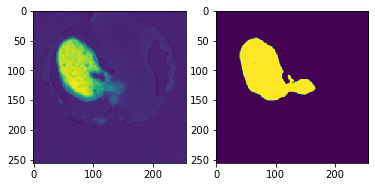

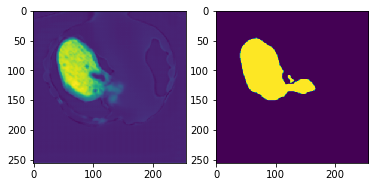

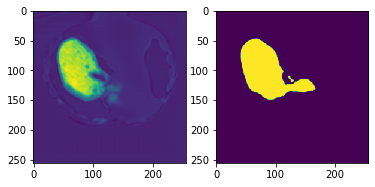

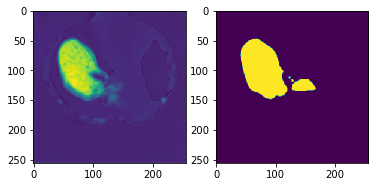

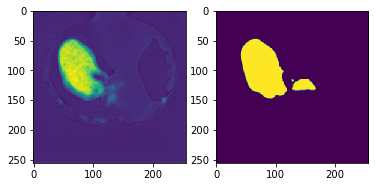

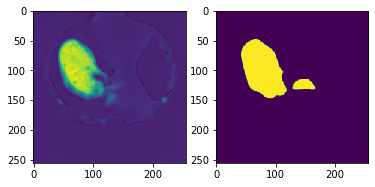

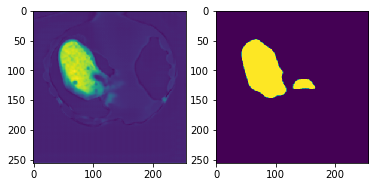

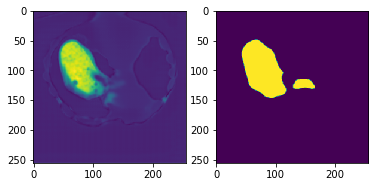

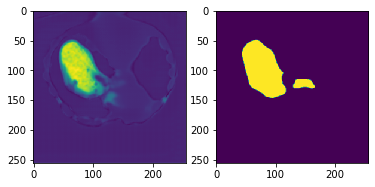

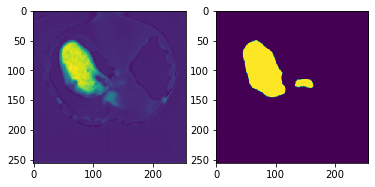

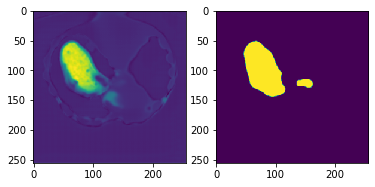

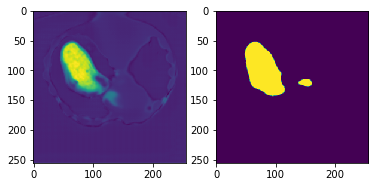

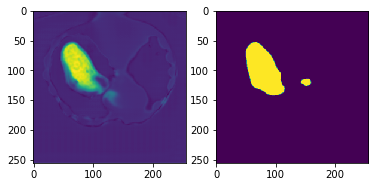

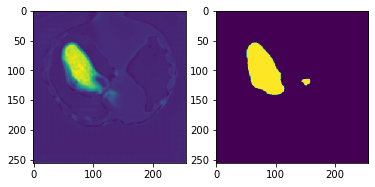

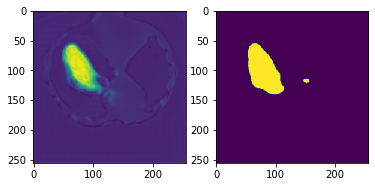

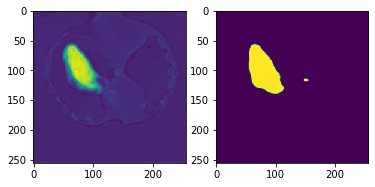

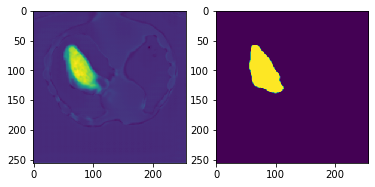

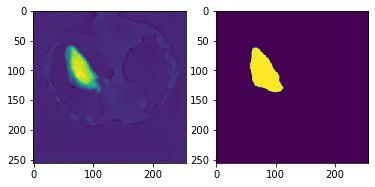

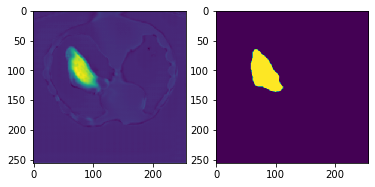

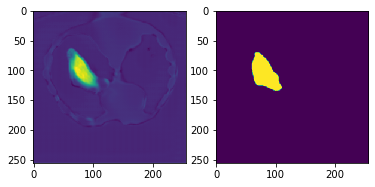

In [21]:
plt.ion()
with torch.no_grad():
    for x,label in dataloaders:
        y=model(x)
        img_y=torch.squeeze(y).numpy()
        img_label = torch.squeeze(label).numpy()  
        plt.figure()
        plt.subplot(1,2,1)
        plt.imshow(img_y)
        plt.subplot(1,2,2)
        plt.imshow(img_label)
        plt.pause(0.01)
    plt.show()